#1.&nbsp; Load Library

In [ ]:
!pip install split-folders
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import glob
import os
import PIL
from PIL import Image
import pathlib
import splitfolders
from sklearn.metrics import classification_report, confusion_matrix
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras import layers, models
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Conv2D, MaxPooling2D, concatenate, BatchNormalization
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.applications import VGG19, ResNet50, DenseNet201, InceptionV3
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from tensorflow.keras import backend as K
from google.colab import files

import warnings
warnings.filterwarnings("ignore")

In [ ]:
import tensorflow as tf
print(tf.__version__)

print(tf.config.list_physical_devices('GPU'))

if tf.config.list_physical_devices('GPU'):
    print("TensorFlow is using GPU.")
else:
    print("TensorFlow is using CPU.")

2.18.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow is using GPU.


#2.&nbsp;Load Dataset

In [ ]:
!kaggle datasets download -d muratkokludataset/rice-image-dataset
!unzip -o rice-image-dataset.zip -d rice-image-dataset

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (55).jpg  
  inflating: rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (550).jpg  
  inflating: rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (5500).jpg  
  inflating: rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (5501).jpg  
  inflating: rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (5502).jpg  
  inflating: rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (5503).jpg  
  inflating: rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (5504).jpg  
  inflating: rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (5505).jpg  
  inflating: rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (5506).jpg  
  inflating: rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (5507).jpg  
  inflating: rice-image-dataset/Rice_Image_Dataset/Karacadag/Karacadag (5508).jpg  
  inflating: rice-im

#3.&nbsp;Dataset Preparation

##3.1. Dataset Loading & Splitting

In [ ]:
data = '/content/rice-image-dataset/Rice_Image_Dataset'
splitfolders.ratio(data, output="imgs", seed=42, ratio=(.7, .3))

os.replace('imgs/val',
           'imgs/test')

Copying files: 75000 files [00:12, 5884.08 files/s]


##3.2.&nbsp;Data Exploration

Kelas Arborio: 15000 gambar
Kelas Basmati: 15000 gambar
Kelas Ipsala: 15000 gambar
Kelas Jasmine: 15000 gambar
Kelas Karacadag: 15000 gambar


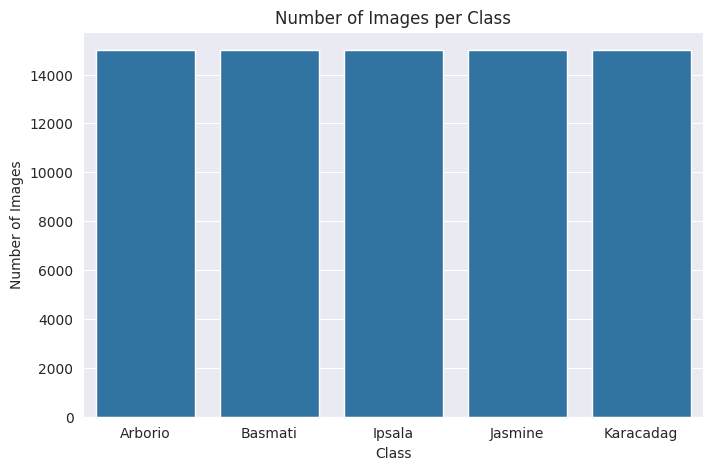

In [ ]:
arborio = glob.glob(os.path.join(data, 'Arborio', '*.jpg'))
bastmati = glob.glob(os.path.join(data, 'Basmati', '*.jpg'))
ipsala = glob.glob(os.path.join(data, 'Ipsala', '*.jpg'))
jasmine = glob.glob(os.path.join(data, 'Jasmine', '*.jpg'))
karacadag = glob.glob(os.path.join(data, 'Karacadag', '*.jpg'))

rice = [arborio, bastmati, ipsala, jasmine, karacadag]
rice_classes = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
rice_count = [len(rice_class) for rice_class in rice]

for rice_class, count in zip(rice_classes, rice_count):
    print(f"Kelas {rice_class}: {count} gambar")

sns.set_style('darkgrid')
plt.figure(figsize=(8, 5))
sns.barplot(x=rice_classes, y=rice_count)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.show()

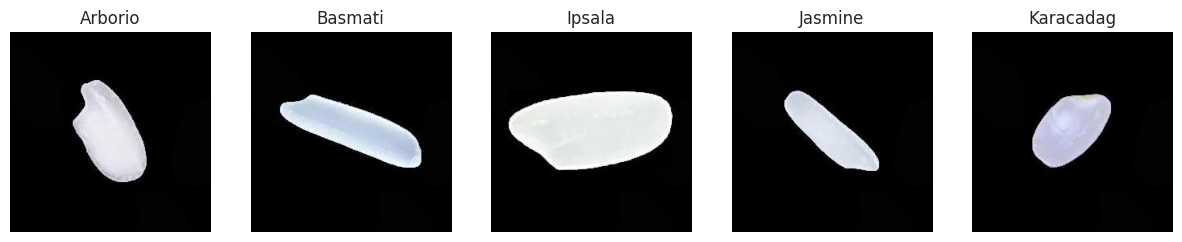

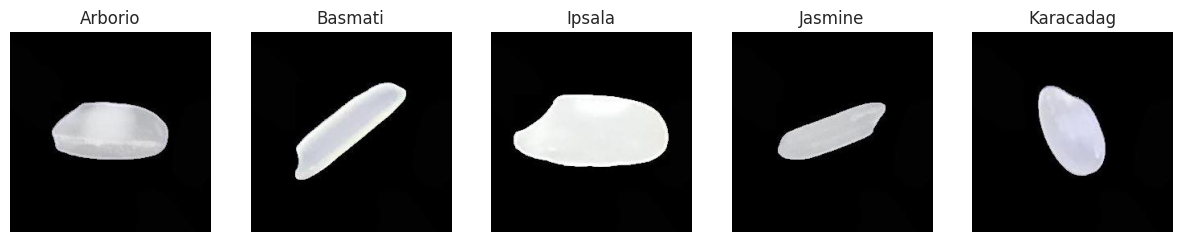

In [ ]:
def load_random_img(base_dir, labels):
    plt.figure(figsize=(15, 5))
    for i, label in enumerate(labels):
        class_dir = os.path.join(base_dir, label)
        if os.path.isdir(class_dir):
            image_files = [f for f in os.listdir(class_dir) if f.endswith('.jpg')]
            if image_files:
                image_path = os.path.join(class_dir, random.choice(image_files))
                sample_img = cv2.imread(image_path)
                if sample_img is not None:
                    plt.subplot(1, len(labels), i + 1)
                    plt.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
                    plt.title(label)
                    plt.axis('off')
    plt.show()

for _ in range(2):
    load_random_img(data, rice_classes)

#4.&nbsp;Data Preprocessing

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255
)

train_data = datagen.flow_from_directory(
    'imgs/train',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    seed=123
)

test_data = datagen.flow_from_directory(
    'imgs/test',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

print(f"Total training samples: {train_data.samples}")
print(f"Total testing samples: {test_data.samples}")


Found 52500 images belonging to 5 classes.
Found 22500 images belonging to 5 classes.
Total training samples: 52500
Total testing samples: 22500


In [ ]:
print(f"Total training samples: {train_data.samples}")
print(f"Total testing samples: {test_data.samples}")

Total training samples: 52500
Total testing samples: 22500


In [ ]:
# Menampilkan jumlah total sampel di setiap kelas untuk training
print("Jumlah sampel per kelas (training):")
for class_name, index in train_data.class_indices.items():
    count = (train_data.classes == index).sum()
    print(f"  {class_name}: {count}")

# Menampilkan jumlah total sampel di setiap kelas untuk testing
print("\nJumlah sampel per kelas (testing):")
for class_name, index in test_data.class_indices.items():
    count = (test_data.classes == index).sum()
    print(f"  {class_name}: {count}")

Jumlah sampel per kelas (training):
  Arborio: 10500
  Basmati: 10500
  Ipsala: 10500
  Jasmine: 10500
  Karacadag: 10500

Jumlah sampel per kelas (testing):
  Arborio: 4500
  Basmati: 4500
  Ipsala: 4500
  Jasmine: 4500
  Karacadag: 4500


Label: Arborio | Min Ori: 0 | Max Ori: 247
Label: Arborio | Min Normalized: 0.0 | Max Normalized: 0.9686274528503418
Label: Basmati | Min Ori: 0 | Max Ori: 255
Label: Basmati | Min Normalized: 0.0 | Max Normalized: 1.0
Label: Ipsala | Min Ori: 0 | Max Ori: 255
Label: Ipsala | Min Normalized: 0.0 | Max Normalized: 1.0
Label: Jasmine | Min Ori: 0 | Max Ori: 255
Label: Jasmine | Min Normalized: 0.0 | Max Normalized: 1.0
Label: Karacadag | Min Ori: 0 | Max Ori: 255
Label: Karacadag | Min Normalized: 0.0 | Max Normalized: 1.0


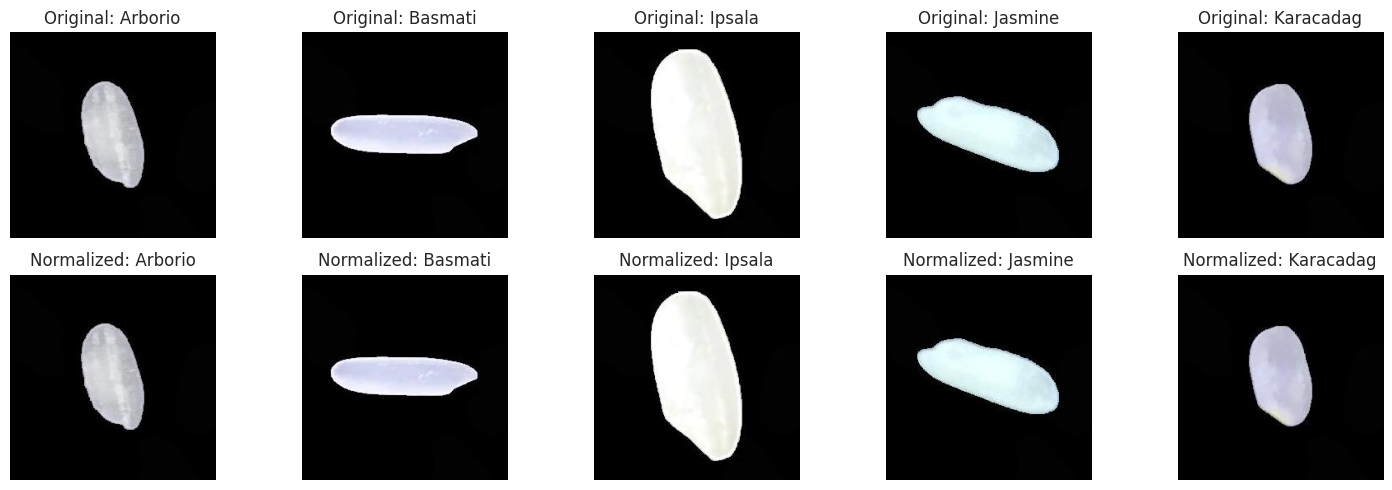

In [ ]:
def load_random_img(base_dir, labels):
    plt.figure(figsize=(15, 5))

    for i, label in enumerate(labels):
        class_dir = os.path.join(base_dir, label)
        if os.path.isdir(class_dir):
            image_files = [f for f in os.listdir(class_dir) if f.endswith('.jpg')]
            if image_files:
                image_path = os.path.join(class_dir, random.choice(image_files))

                sample_img = cv2.imread(image_path)
                if sample_img is not None:
                    sample_img_rgb = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
                    sample_img_normalized = sample_img_rgb.astype(np.float32) / 255.0

                    print(f"Label: {label} | Min Ori: {sample_img_rgb.min()} | Max Ori: {sample_img_rgb.max()}")
                    print(f"Label: {label} | Min Normalized: {sample_img_normalized.min()} | Max Normalized: {sample_img_normalized.max()}")

                    plt.subplot(2, len(labels), i + 1)
                    plt.imshow(sample_img_rgb)
                    plt.title(f"Original: {label}")
                    plt.axis('off')

                    plt.subplot(2, len(labels), len(labels) + i + 1)
                    plt.imshow(sample_img_normalized)
                    plt.title(f"Normalized: {label}")
                    plt.axis('off')

    plt.tight_layout()
    plt.show()

load_random_img(data, rice_classes)


In [ ]:
# Just for sample
image = Image.open("/content/imgs/train/Arborio/Arborio (1).jpg")
image_array = np.array(image)

In [ ]:
# Pixel array before normalization
mid_row, mid_col = image_array.shape[0] // 2, image_array.shape[1] // 2
print(image_array[mid_row-5:mid_row+5, mid_col-5:mid_col+5])

[[[238 239 244]
  [236 237 242]
  [233 234 239]
  [231 232 237]
  [230 231 236]
  [232 233 238]
  [234 235 240]
  [236 237 242]
  [236 237 242]
  [234 235 240]]

 [[238 239 244]
  [237 238 243]
  [234 235 240]
  [232 233 238]
  [231 232 237]
  [233 234 239]
  [235 236 241]
  [236 237 242]
  [235 236 241]
  [234 235 240]]

 [[239 240 245]
  [237 238 243]
  [235 236 241]
  [233 234 239]
  [232 233 238]
  [233 234 239]
  [235 236 241]
  [237 238 243]
  [235 236 241]
  [235 236 241]]

 [[238 239 244]
  [237 238 243]
  [235 236 241]
  [234 235 240]
  [233 234 239]
  [234 235 240]
  [235 236 241]
  [236 237 242]
  [234 235 240]
  [235 236 241]]

 [[237 238 243]
  [236 237 242]
  [235 236 241]
  [234 235 240]
  [233 234 239]
  [234 235 240]
  [235 236 241]
  [235 236 241]
  [233 234 239]
  [235 236 241]]

 [[236 237 242]
  [235 236 241]
  [234 235 240]
  [233 234 239]
  [233 234 239]
  [233 234 239]
  [233 234 239]
  [234 235 240]
  [233 234 239]
  [235 236 241]]

 [[234 235 240]
  [234 235 2

In [ ]:
# Pixel array after normalization
image_array = np.array(image)
image_array_normalized = image_array / 255.0

mid_row, mid_col = image_array_normalized.shape[0] // 2, image_array_normalized.shape[1] // 2
print(image_array_normalized[mid_row-5:mid_row+5, mid_col-5:mid_col+5])

[[[0.93333333 0.9372549  0.95686275]
  [0.9254902  0.92941176 0.94901961]
  [0.91372549 0.91764706 0.9372549 ]
  [0.90588235 0.90980392 0.92941176]
  [0.90196078 0.90588235 0.9254902 ]
  [0.90980392 0.91372549 0.93333333]
  [0.91764706 0.92156863 0.94117647]
  [0.9254902  0.92941176 0.94901961]
  [0.9254902  0.92941176 0.94901961]
  [0.91764706 0.92156863 0.94117647]]

 [[0.93333333 0.9372549  0.95686275]
  [0.92941176 0.93333333 0.95294118]
  [0.91764706 0.92156863 0.94117647]
  [0.90980392 0.91372549 0.93333333]
  [0.90588235 0.90980392 0.92941176]
  [0.91372549 0.91764706 0.9372549 ]
  [0.92156863 0.9254902  0.94509804]
  [0.9254902  0.92941176 0.94901961]
  [0.92156863 0.9254902  0.94509804]
  [0.91764706 0.92156863 0.94117647]]

 [[0.9372549  0.94117647 0.96078431]
  [0.92941176 0.93333333 0.95294118]
  [0.92156863 0.9254902  0.94509804]
  [0.91372549 0.91764706 0.9372549 ]
  [0.90980392 0.91372549 0.93333333]
  [0.91372549 0.91764706 0.9372549 ]
  [0.92156863 0.9254902  0.9450980

In [ ]:
# Check label type
# if one hot -> loss categorical_crossentropy
# if binary -> loss sparse_categorical_crossentropy
images, labels = next(train_data)
print(labels)
print(labels.shape)

[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1.

#5.&nbsp;DENS-INCEP Modeling

##5.1. Model Architecture Design

In [ ]:
# just check all layers in DenseNet201, ref https://github.com/keras-team/keras/blob/v3.3.3/keras/src/applications/densenet.py#L382-L407
''' Dense block 1 started at conv2
    Dense block 2 started at conv3
    Dense block 3 started at conv4
    Dense block 4 started at conv5

    as well as trans layer started at pool 2
    and so on'''

model = DenseNet201(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
model.summary()

82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "densenet201"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_3          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 20,242,984 (77.22 MB)

 Trainable params: 20,013,928 (76.35 MB)

 Non-trainable params: 229,056 (894.75 KB)

In [ ]:
# fix inception module -> ouput shape 28, 28, 512
def inception_module(input_tensor):
    conv1x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(input_tensor)
    conv3x3 = Conv2D(256, (3, 3), padding='same', activation='relu')(input_tensor)
    conv5x5 = Conv2D(64, (5, 5), padding='same', activation='relu')(input_tensor)
    maxpool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input_tensor)
    maxpool_conv1x1 = Conv2D(64, (1, 1), padding='same', activation='relu')(maxpool)
    output = concatenate([conv1x1, conv3x3, conv5x5, maxpool_conv1x1], axis=-1)
    return output

def dens_incep(input_shape=(224, 224, 3), num_classes=5):
    inputs = Input(shape=input_shape)
    densenet_base = DenseNet201(include_top=False, weights='imagenet', input_tensor=inputs)

    for layer in densenet_base.layers:
        layer.trainable = False

    x = densenet_base.get_layer("pool4_pool").output
    x = inception_module(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

densincep_model = dens_incep()
densincep_model.summary()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 15,174,213 (57.89 MB)

 Trainable params: 3,935,749 (15.01 MB)

 Non-trainable params: 11,238,464 (42.87 MB)

##5.3.&nbsp;Model Training

### 5.3.1 Scenario 1


Learning Rate 0.001

#### Epoch 10

In [ ]:
# Model Training 10 Epoch
optimizer = Adam(learning_rate=0.001)
loss = CategoricalCrossentropy()
metrics = ['accuracy']

densincep_model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

history_densincep_model_10_epoch = densincep_model.fit(train_data,
                    epochs=10,
                    validation_data=test_data)

Epoch 1/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 342s 369ms/step - accuracy: 0.9144 - loss: 0.2433 - val_accuracy: 0.9868 - val_loss: 0.0441
Epoch 2/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 312s 314ms/step - accuracy: 0.9902 - loss: 0.0298 - val_accuracy: 0.9963 - val_loss: 0.0111
Epoch 3/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 262s 314ms/step - accuracy: 0.9928 - loss: 0.0230 - val_accuracy: 0.9961 - val_loss: 0.0111
Epoch 4/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 270s 324ms/step - accuracy: 0.9936 - loss: 0.0206 - val_accuracy: 0.9970 - val_loss: 0.0089
Epoch 5/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 314s 314ms/step - accuracy: 0.9965 - loss: 0.0113 - val_accuracy: 0.9944 - val_loss: 0.0159
Epoch 6/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 259s 314ms/step - accuracy: 0.9960 - loss: 0.0128 - val_accuracy: 0.9979 - val_loss: 0.0070
Epoch 7/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 258s 313ms/step - accuracy: 0.9972 - loss: 0.0097 - val_accuracy: 0.9973 - val_loss: 0.0070
Epoch 8/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 258s 314ms/step - accuracy: 0.9978 -

In [ ]:
densincep_model.save('densincep_model_10epoch.keras')

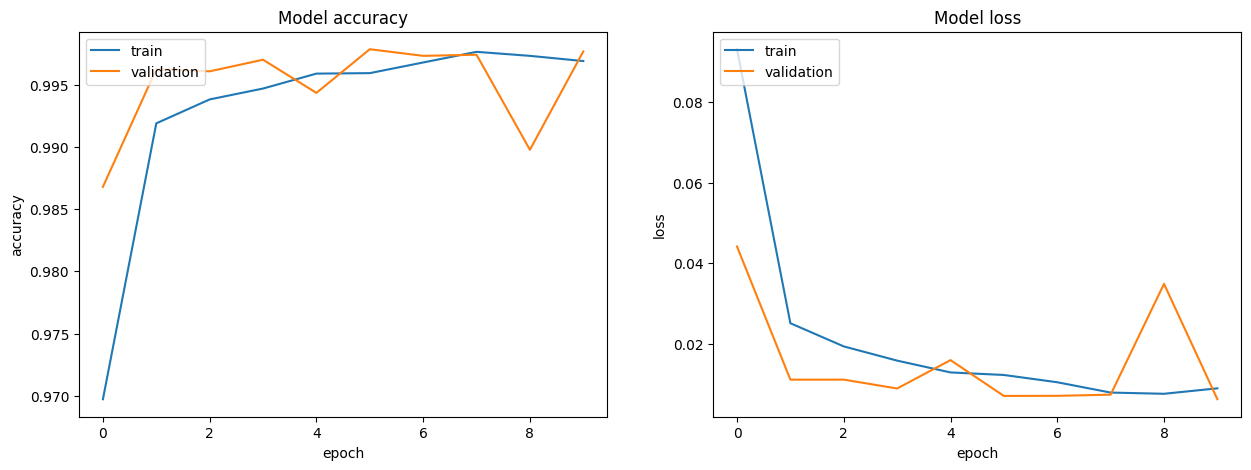

In [ ]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_train_history(history_densincep_model_10_epoch)

#### Epoch 20

In [ ]:
optimizer = Adam(learning_rate=0.001)
loss = CategoricalCrossentropy()
metrics = ['accuracy']

densincep_model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

history_densincep_model_20_epoch = densincep_model.fit(train_data,
                    epochs=20,
                    validation_data=test_data)

Epoch 1/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 366s 372ms/step - accuracy: 0.9222 - loss: 0.2399 - val_accuracy: 0.9846 - val_loss: 0.0463
Epoch 2/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 246s 300ms/step - accuracy: 0.9898 - loss: 0.0308 - val_accuracy: 0.9843 - val_loss: 0.0449
Epoch 3/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 245s 299ms/step - accuracy: 0.9934 - loss: 0.0217 - val_accuracy: 0.9956 - val_loss: 0.0127
Epoch 4/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 246s 299ms/step - accuracy: 0.9938 - loss: 0.0186 - val_accuracy: 0.9961 - val_loss: 0.0110
Epoch 5/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 246s 299ms/step - accuracy: 0.9960 - loss: 0.0119 - val_accuracy: 0.9974 - val_loss: 0.0084
Epoch 6/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 245s 299ms/step - accuracy: 0.9964 - loss: 0.0115 - val_accuracy: 0.9935 - val_loss: 0.0199
Epoch 7/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 246s 299ms/step - accuracy: 0.9966 - loss: 0.0116 - val_accuracy: 0.9975 - val_loss: 0.0063
Epoch 8/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 256s 312ms/step - accuracy: 0.9975 -

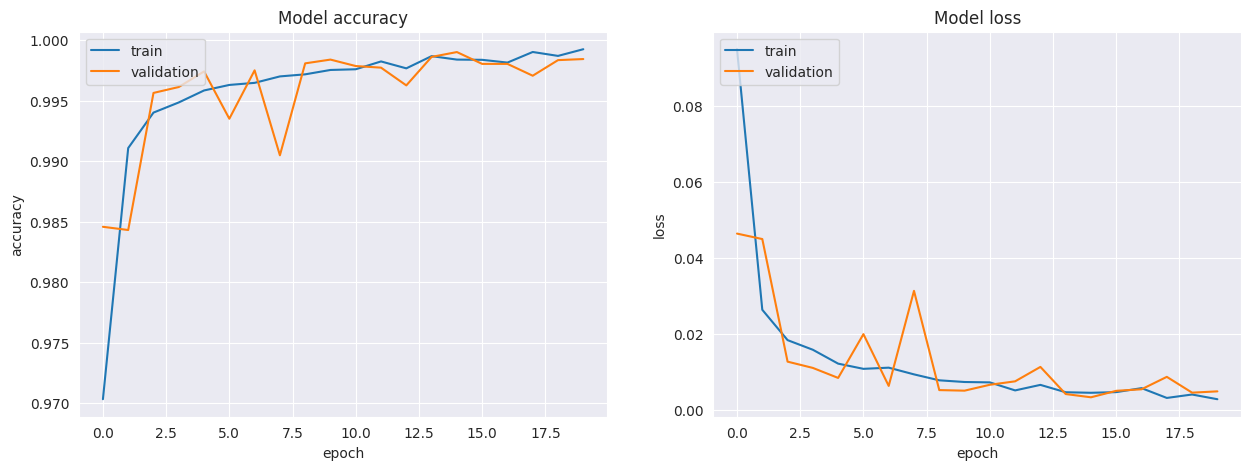

In [ ]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_train_history(history_densincep_model_20_epoch)

In [ ]:
densincep_model.save('densincep_model_20epoch_lr001.keras')

In [ ]:
# Model Training
optimizer = Adam(learning_rate=0.001)
loss = CategoricalCrossentropy()
metrics = ['accuracy']

densincep_model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

history_densincep_model_20_epoch = densincep_model.fit(train_data,
                    epochs=20,
                    validation_data=test_data)

Epoch 1/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 321s 339ms/step - accuracy: 0.9223 - loss: 0.2399 - val_accuracy: 0.9842 - val_loss: 0.0470
Epoch 2/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 233s 284ms/step - accuracy: 0.9899 - loss: 0.0310 - val_accuracy: 0.9818 - val_loss: 0.0530
Epoch 3/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 236s 287ms/step - accuracy: 0.9928 - loss: 0.0228 - val_accuracy: 0.9947 - val_loss: 0.0144
Epoch 4/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 236s 288ms/step - accuracy: 0.9938 - loss: 0.0205 - val_accuracy: 0.9973 - val_loss: 0.0068
Epoch 5/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 236s 288ms/step - accuracy: 0.9963 - loss: 0.0110 - val_accuracy: 0.9954 - val_loss: 0.0139
Epoch 6/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 237s 288ms/step - accuracy: 0.9961 - loss: 0.0119 - val_accuracy: 0.9971 - val_loss: 0.0090
Epoch 7/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 236s 288ms/step - accuracy: 0.9948 - loss: 0.0148 - val_accuracy: 0.9972 - val_loss: 0.0074
Epoch 8/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 259s 285ms/step - accuracy: 0.9974 -

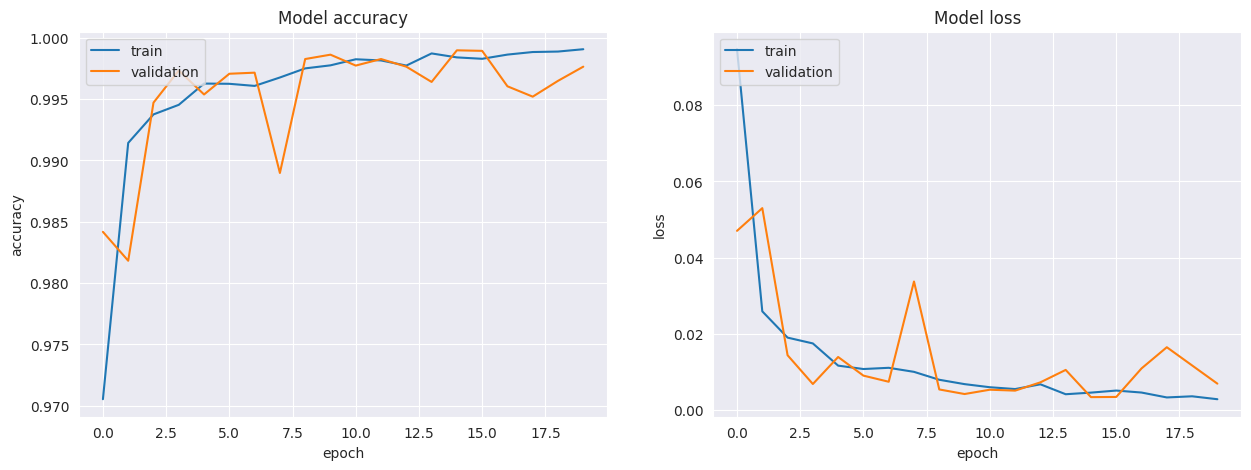

In [ ]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_train_history(history_densincep_model_20_epoch)

In [ ]:
densincep_model.save('densincep_model_20epoch_lr001_2.keras')

#### Epoch 30

In [ ]:
optimizer = Adam(learning_rate=0.001)
loss = CategoricalCrossentropy()
metrics = ['accuracy']

densincep_model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

history_densincep_model = densincep_model.fit(train_data,
                    epochs=30,
                    validation_data=test_data)

Epoch 1/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 351s 378ms/step - accuracy: 0.9101 - loss: 0.2561 - val_accuracy: 0.9825 - val_loss: 0.0490
Epoch 2/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 309s 321ms/step - accuracy: 0.9914 - loss: 0.0260 - val_accuracy: 0.9895 - val_loss: 0.0294
Epoch 3/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 330s 330ms/step - accuracy: 0.9937 - loss: 0.0178 - val_accuracy: 0.9949 - val_loss: 0.0165
Epoch 4/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 271s 329ms/step - accuracy: 0.9945 - loss: 0.0163 - val_accuracy: 0.9962 - val_loss: 0.0091
Epoch 5/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 315s 320ms/step - accuracy: 0.9962 - loss: 0.0110 - val_accuracy: 0.9977 - val_loss: 0.0075
Epoch 6/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 264s 320ms/step - accuracy: 0.9961 - loss: 0.0122 - val_accuracy: 0.9978 - val_loss: 0.0067
Epoch 7/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 263s 320ms/step - accuracy: 0.9973 - loss: 0.0082 - val_accuracy: 0.9970 - val_loss: 0.0087
Epoch 8/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 264s 320ms/step - accuracy: 0.9966 -

In [ ]:
densincep_model.save('densincep_model_final.keras')

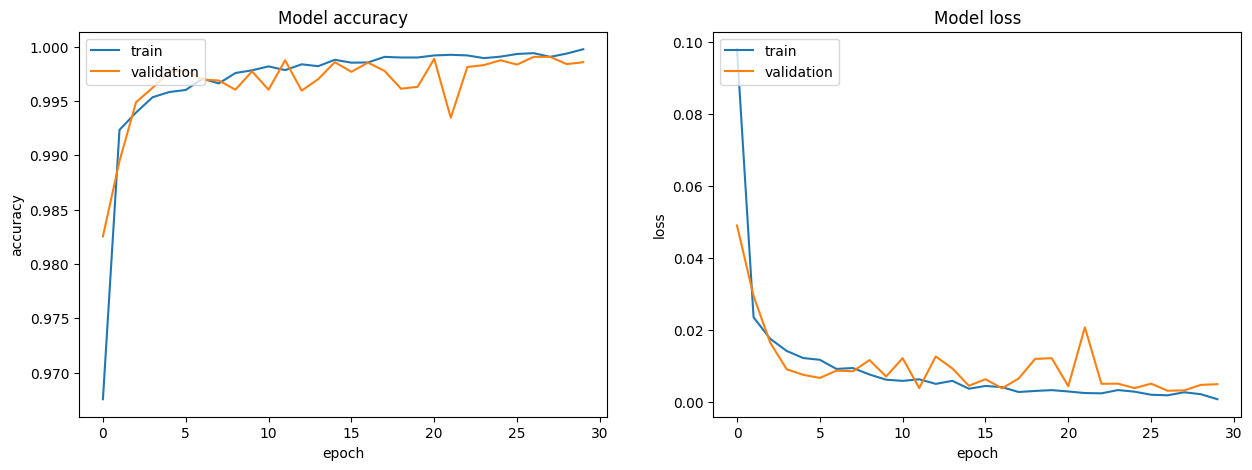

In [ ]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_train_history(history_densincep_model)

### 5.3.2 Scenario 2


Learning Rate 0.0001

#### Epoch 10

In [ ]:
# Model Training
optimizer = Adam(learning_rate=0.0001)
loss = CategoricalCrossentropy()
metrics = ['accuracy']

densincep_model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

history_densincep_model_10_epoch_lr0001 = densincep_model.fit(train_data,
                    epochs=10,
                    validation_data=test_data)

Epoch 1/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 314s 344ms/step - accuracy: 0.8877 - loss: 0.4995 - val_accuracy: 0.9876 - val_loss: 0.0448
Epoch 2/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 256s 312ms/step - accuracy: 0.9879 - loss: 0.0408 - val_accuracy: 0.9935 - val_loss: 0.0223
Epoch 3/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 251s 299ms/step - accuracy: 0.9924 - loss: 0.0258 - val_accuracy: 0.9921 - val_loss: 0.0235
Epoch 4/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 261s 297ms/step - accuracy: 0.9934 - loss: 0.0225 - val_accuracy: 0.9956 - val_loss: 0.0132
Epoch 5/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 244s 298ms/step - accuracy: 0.9952 - loss: 0.0154 - val_accuracy: 0.9960 - val_loss: 0.0136
Epoch 6/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 255s 311ms/step - accuracy: 0.9948 - loss: 0.0162 - val_accuracy: 0.9944 - val_loss: 0.0169
Epoch 7/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 252s 299ms/step - accuracy: 0.9959 - loss: 0.0135 - val_accuracy: 0.9965 - val_loss: 0.0100
Epoch 8/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 245s 299ms/step - accuracy: 0.9958 -

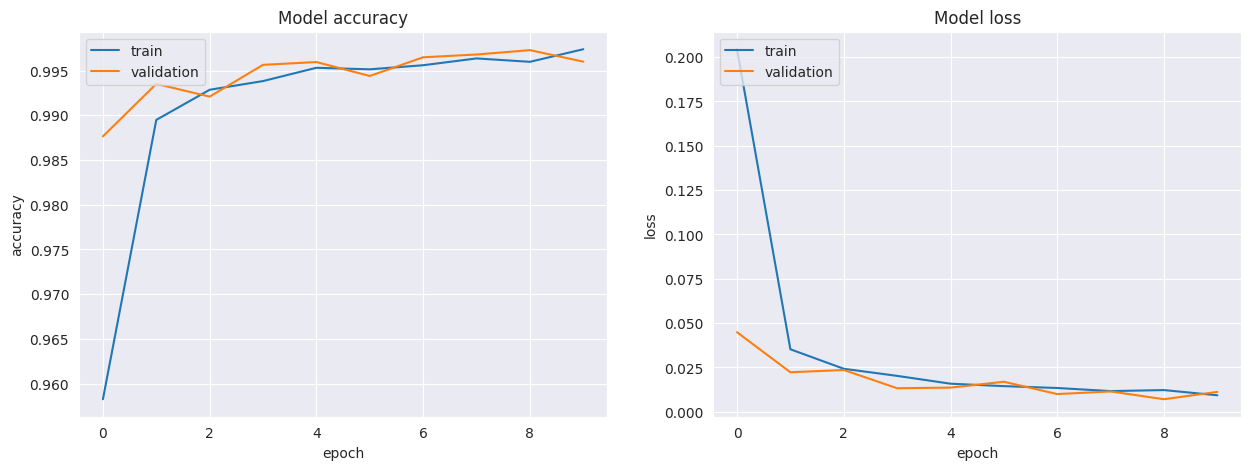

In [ ]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_train_history(history_densincep_model_10_epoch_lr0001)

In [ ]:
densincep_model.save('densincep_model_10epoch_lr0001.keras')

In [ ]:
# Model Training
optimizer = Adam(learning_rate=0.0001)
loss = CategoricalCrossentropy()
metrics = ['accuracy']

densincep_model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

history_densincep_model_10_epoch_lr0001 = densincep_model.fit(train_data,
                    epochs=10,
                    validation_data=test_data)

Epoch 1/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 340s 359ms/step - accuracy: 0.8791 - loss: 0.5062 - val_accuracy: 0.9888 - val_loss: 0.0428
Epoch 2/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 242s 295ms/step - accuracy: 0.9877 - loss: 0.0435 - val_accuracy: 0.9914 - val_loss: 0.0293
Epoch 3/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 254s 309ms/step - accuracy: 0.9919 - loss: 0.0271 - val_accuracy: 0.9931 - val_loss: 0.0241
Epoch 4/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 242s 295ms/step - accuracy: 0.9928 - loss: 0.0238 - val_accuracy: 0.9946 - val_loss: 0.0168
Epoch 5/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 242s 295ms/step - accuracy: 0.9941 - loss: 0.0181 - val_accuracy: 0.9952 - val_loss: 0.0151
Epoch 6/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 262s 295ms/step - accuracy: 0.9954 - loss: 0.0156 - val_accuracy: 0.9958 - val_loss: 0.0142
Epoch 7/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 242s 295ms/step - accuracy: 0.9957 - loss: 0.0139 - val_accuracy: 0.9948 - val_loss: 0.0142
Epoch 8/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 263s 296ms/step - accuracy: 0.9964 -

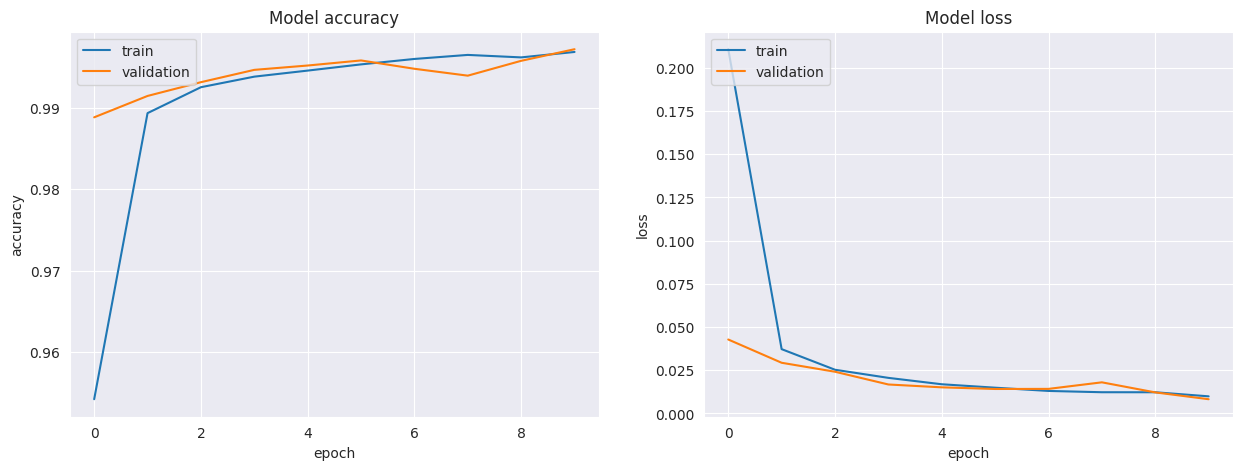

In [ ]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_train_history(history_densincep_model_10_epoch_lr0001)

In [ ]:
densincep_model.save('densincep_model_10epoch_lr0001.keras')

#### Epoch 20

In [ ]:
# Model Training
optimizer = Adam(learning_rate=0.0001)
loss = CategoricalCrossentropy()
metrics = ['accuracy']

densincep_model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

history_densincep_model_20_epoch_lr0001 = densincep_model.fit(train_data,
                    epochs=20,
                    validation_data=test_data)

Epoch 1/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 309s 342ms/step - accuracy: 0.8820 - loss: 0.5050 - val_accuracy: 0.9875 - val_loss: 0.0481
Epoch 2/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 243s 297ms/step - accuracy: 0.9867 - loss: 0.0446 - val_accuracy: 0.9929 - val_loss: 0.0253
Epoch 3/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 243s 296ms/step - accuracy: 0.9915 - loss: 0.0285 - val_accuracy: 0.9948 - val_loss: 0.0166
Epoch 4/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 243s 295ms/step - accuracy: 0.9937 - loss: 0.0210 - val_accuracy: 0.9944 - val_loss: 0.0171
Epoch 5/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 243s 296ms/step - accuracy: 0.9948 - loss: 0.0181 - val_accuracy: 0.9963 - val_loss: 0.0116
Epoch 6/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 243s 296ms/step - accuracy: 0.9947 - loss: 0.0164 - val_accuracy: 0.9964 - val_loss: 0.0116
Epoch 7/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 243s 296ms/step - accuracy: 0.9953 - loss: 0.0141 - val_accuracy: 0.9928 - val_loss: 0.0214
Epoch 8/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 243s 296ms/step - accuracy: 0.9966 -

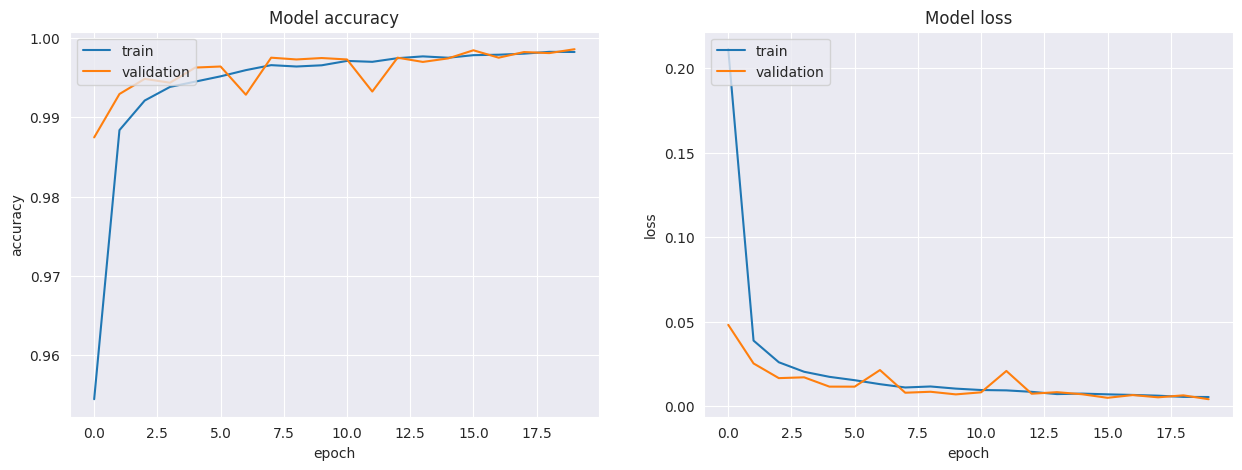

In [ ]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_train_history(history_densincep_model_20_epoch_lr0001)

In [ ]:
densincep_model.save('densincep_model_20epoch_lr0001.keras')

In [ ]:
# Model Training
optimizer = Adam(learning_rate=0.0001)
loss = CategoricalCrossentropy()
metrics = ['accuracy']

densincep_model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

history_densincep_model_20_epoch_lr0001 = densincep_model.fit(train_data,
                    epochs=20,
                    validation_data=test_data)

Epoch 1/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 360s 394ms/step - accuracy: 0.8878 - loss: 0.4996 - val_accuracy: 0.9877 - val_loss: 0.0447
Epoch 2/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 233s 284ms/step - accuracy: 0.9879 - loss: 0.0408 - val_accuracy: 0.9936 - val_loss: 0.0222
Epoch 3/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 237s 289ms/step - accuracy: 0.9924 - loss: 0.0258 - val_accuracy: 0.9921 - val_loss: 0.0236
Epoch 4/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 251s 306ms/step - accuracy: 0.9934 - loss: 0.0225 - val_accuracy: 0.9956 - val_loss: 0.0132
Epoch 5/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 249s 291ms/step - accuracy: 0.9952 - loss: 0.0153 - val_accuracy: 0.9960 - val_loss: 0.0137
Epoch 6/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 238s 290ms/step - accuracy: 0.9948 - loss: 0.0162 - val_accuracy: 0.9944 - val_loss: 0.0168
Epoch 7/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 238s 290ms/step - accuracy: 0.9960 - loss: 0.0135 - val_accuracy: 0.9965 - val_loss: 0.0098
Epoch 8/20
821/821 ━━━━━━━━━━━━━━━━━━━━ 239s 292ms/step - accuracy: 0.9959 -

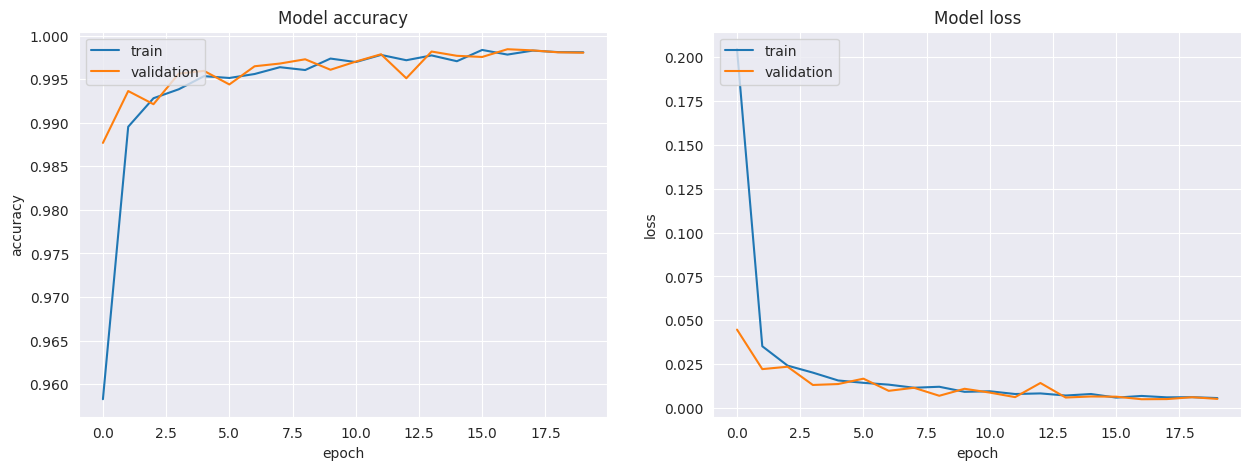

In [ ]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_train_history(history_densincep_model_20_epoch_lr0001)

In [ ]:
densincep_model.save('densincep_model_20epoch_lr0001_2.keras')

#### Epoch 30

In [ ]:
# Model Training
optimizer = Adam(learning_rate=0.0001)
loss = CategoricalCrossentropy()
metrics = ['accuracy']

densincep_model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

history_densincep_model_30_epoch_lr0001 = densincep_model.fit(train_data,
                    epochs=30,
                    validation_data=test_data)

Epoch 1/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 357s 375ms/step - accuracy: 0.8790 - loss: 0.5064 - val_accuracy: 0.9887 - val_loss: 0.0428
Epoch 2/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 251s 306ms/step - accuracy: 0.9877 - loss: 0.0435 - val_accuracy: 0.9914 - val_loss: 0.0294
Epoch 3/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 250s 305ms/step - accuracy: 0.9918 - loss: 0.0271 - val_accuracy: 0.9931 - val_loss: 0.0241
Epoch 4/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 251s 305ms/step - accuracy: 0.9927 - loss: 0.0238 - val_accuracy: 0.9946 - val_loss: 0.0167
Epoch 5/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 251s 305ms/step - accuracy: 0.9941 - loss: 0.0181 - val_accuracy: 0.9951 - val_loss: 0.0151
Epoch 6/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 250s 305ms/step - accuracy: 0.9953 - loss: 0.0156 - val_accuracy: 0.9957 - val_loss: 0.0142
Epoch 7/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 251s 305ms/step - accuracy: 0.9957 - loss: 0.0139 - val_accuracy: 0.9947 - val_loss: 0.0143
Epoch 8/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 260s 317ms/step - accuracy: 0.9963 -

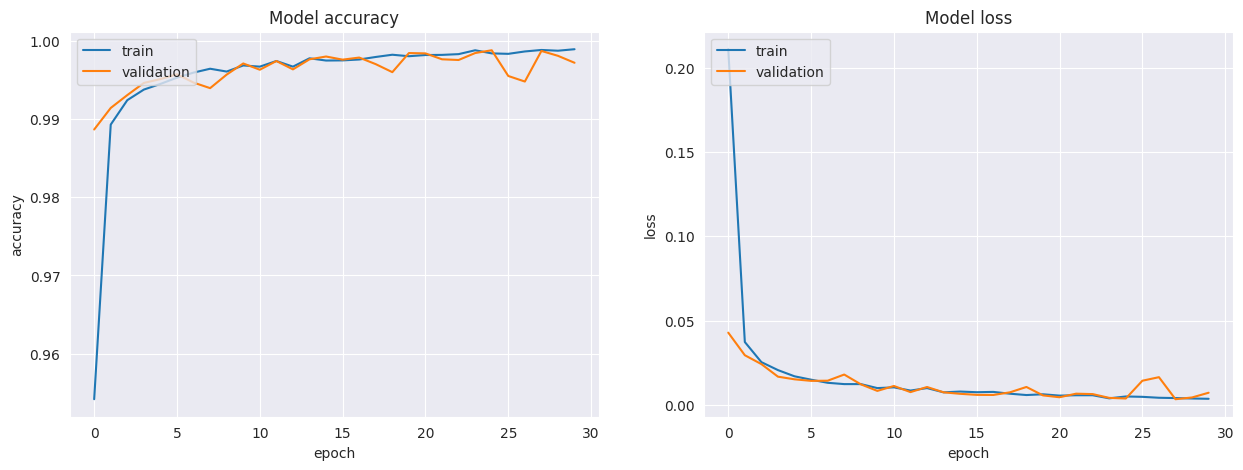

In [ ]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_train_history(history_densincep_model_30_epoch_lr0001)

In [ ]:
densincep_model.save('densincep_model_30epoch_lr0001.keras')

#6.&nbsp;Model Evaluation

Below shows the evaluation of the best model. <br>
Epoch 30

##6.1.&nbsp;Confusion Matrix




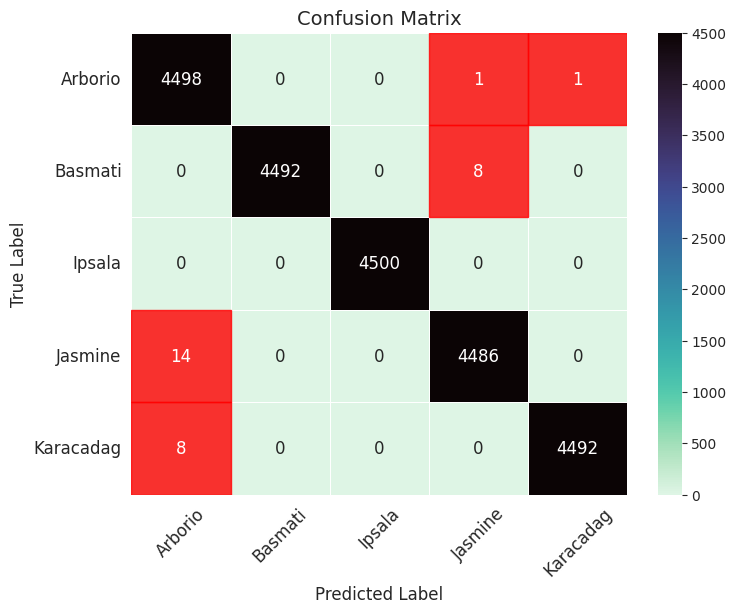

In [ ]:
f, ax = plt.subplots(figsize=(8, 6))
cmap = sns.color_palette("mako_r", as_cmap=True)

heatmap = sns.heatmap(
    confusion_mtx,
    annot=True,
    linewidths=0.5,
    linecolor="white",
    fmt='d',
    ax=ax,
    cmap=cmap,
    annot_kws={"size": 12}
)

for i in range(confusion_mtx.shape[0]):
    for j in range(confusion_mtx.shape[1]):
        if i != j and confusion_mtx[i, j] != 0:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color='red', alpha=0.8))
            text = heatmap.texts[i * confusion_mtx.shape[1] + j]
            text.set_color("white")

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
ax.xaxis.set_ticklabels(test_data.class_indices.keys(), fontsize=12, rotation=45)
ax.yaxis.set_ticklabels(test_data.class_indices.keys(), fontsize=12, rotation=0)
plt.show()

##6.2.&nbsp;ROC Curve

352/352 ━━━━━━━━━━━━━━━━━━━━ 119s 260ms/step


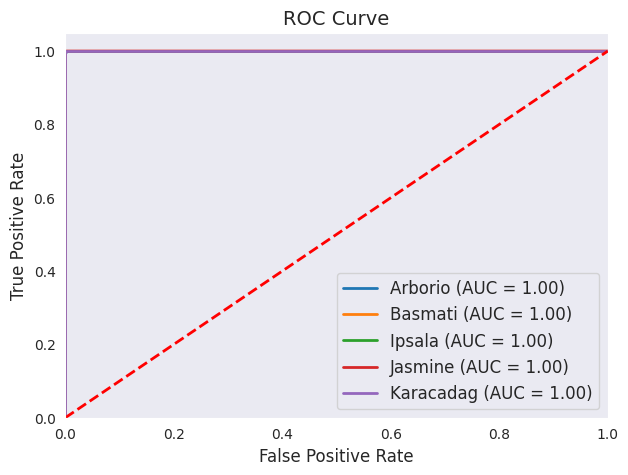

In [ ]:
# Clearly & Readability Legend
y_true = test_data.classes
y_true_binarized = label_binarize(y_true, classes=[0, 1, 2, 3, 4])
y_pred = densincep_model.predict(test_data)

n_classes = y_true_binarized.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(7, 5))
for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        lw=2,
        label=f'{rice_classes[i]} (AUC = {roc_auc[i]:0.2f})'
    )

plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid()
plt.show()

##6.4.&nbsp;Classification Report

In [ ]:
num_classes = len(rice_classes)
accuracy_per_class = []
sensitivity_per_class = []
specificity_per_class = []

for i in range(num_classes):
    TP = confusion_mtx[i, i]
    FP = sum(confusion_mtx[:, i]) - TP
    FN = sum(confusion_mtx[i, :]) - TP
    TN = sum(sum(confusion_mtx)) - (TP + FP + FN)

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

    accuracy_per_class.append(accuracy * 100)
    sensitivity_per_class.append(sensitivity * 100)
    specificity_per_class.append(specificity * 100)

results_df = pd.DataFrame({
    "Class": rice_classes,
    "Accuracy (%)": accuracy_per_class,
    "Sensitivity (%)": sensitivity_per_class,
    "Specificity (%)": specificity_per_class
})

avg_accuracy = np.mean(accuracy_per_class)
avg_sensitivity = np.mean(sensitivity_per_class)
avg_specificity = np.mean(specificity_per_class)

results_df.loc["Average"] = ["Average", avg_accuracy, avg_sensitivity, avg_specificity]

results_df

Class  Accuracy (%)  Sensitivity (%)  Specificity (%)
0          Arborio     99.893333        99.955556        99.877778
1          Basmati     99.964444        99.822222       100.000000
2           Ipsala    100.000000       100.000000       100.000000
3          Jasmine     99.897778        99.688889        99.950000
4        Karacadag     99.960000        99.822222        99.994444
Average    Average     99.943111        99.857778        99.964444

#7.&nbsp;Sanity Check

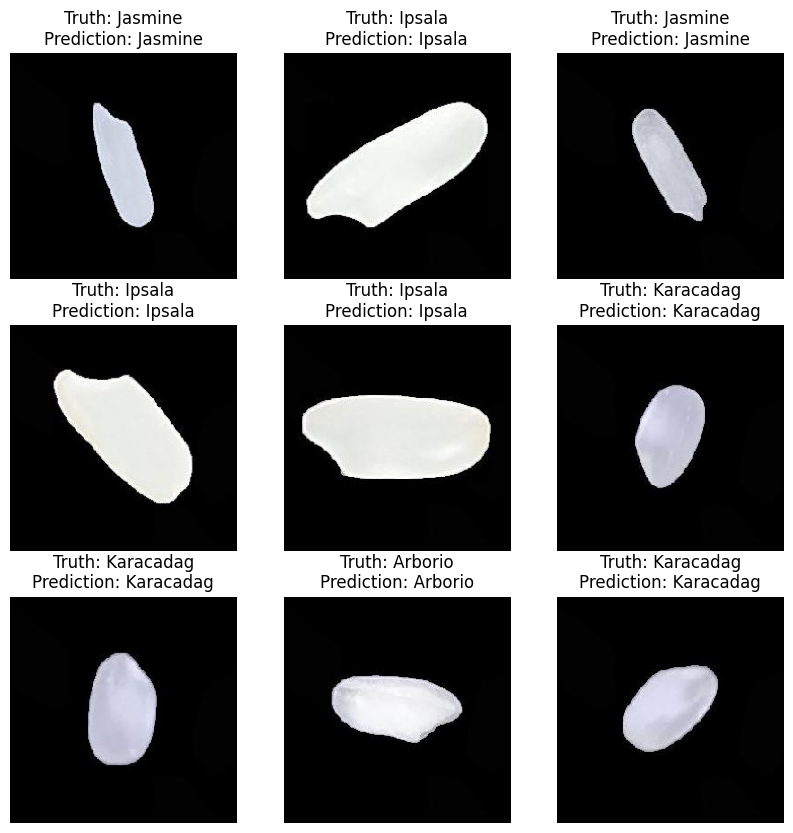

In [ ]:
x, label = next(train_data)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i])
    result = np.where(label[i] == 1)
    predict = densincep_model(tf.expand_dims(x[i], 0))
    score = tf.nn.softmax(predict[0])
    score_label = rice_classes[np.argmax(score)]
    plt.title(f'Truth: {rice_classes[result[0][0]]}\nPrediction: {score_label}')
    plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


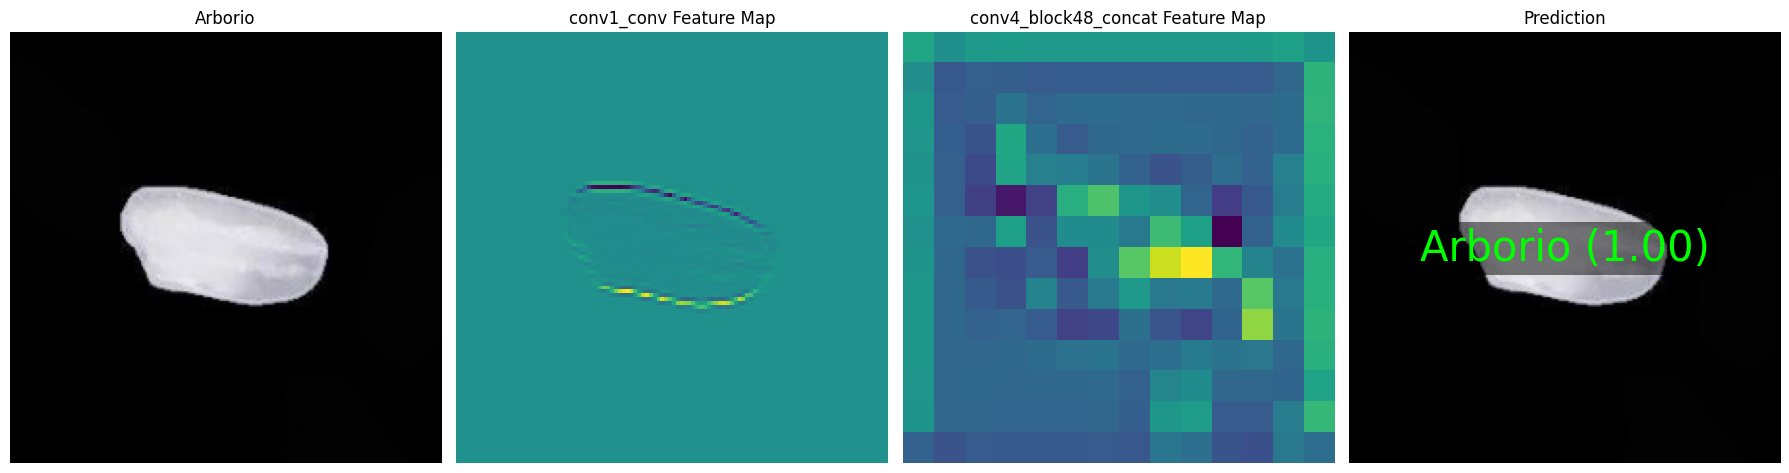

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


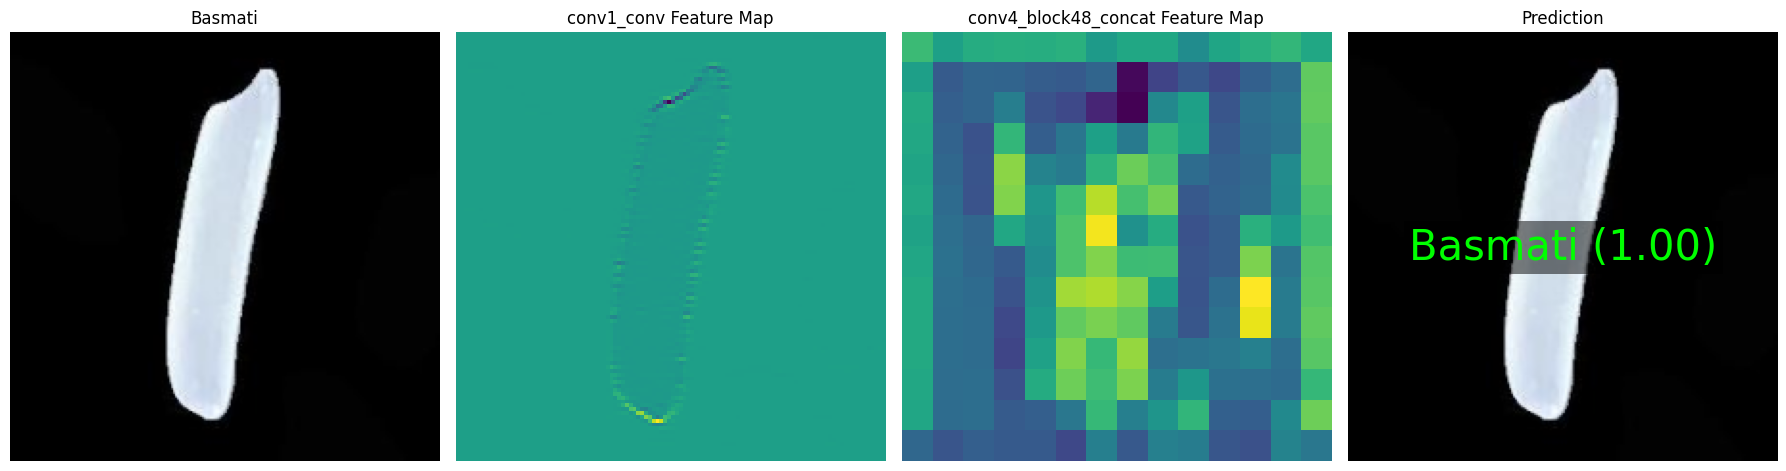

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


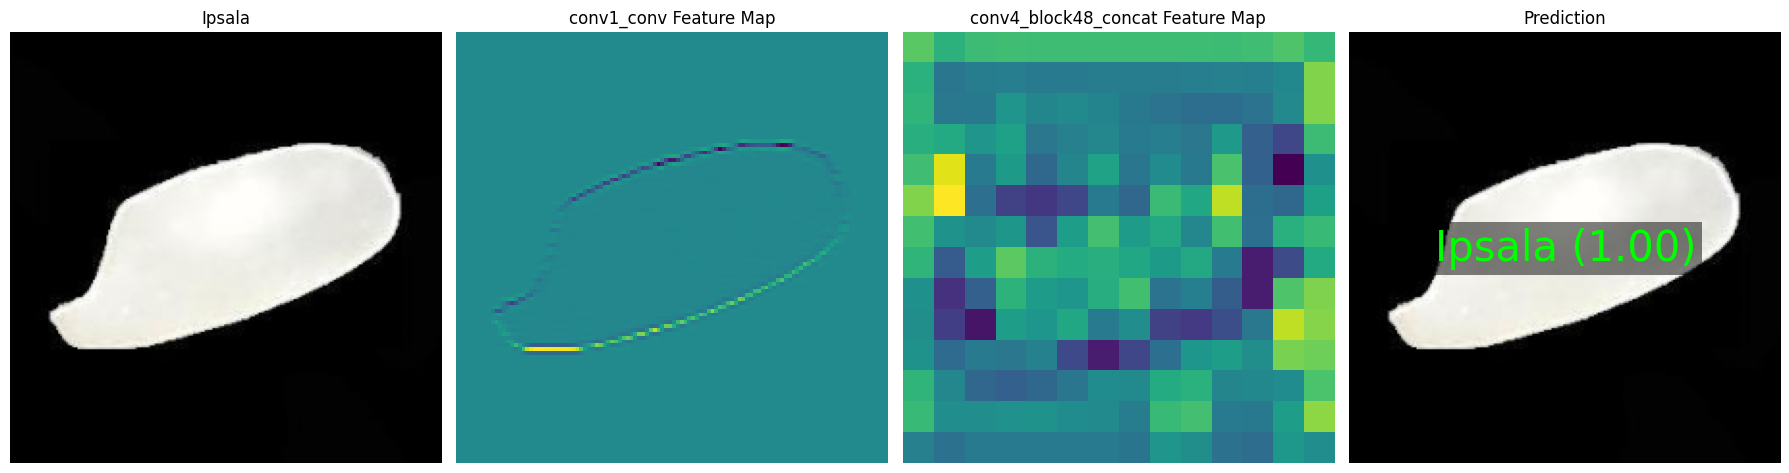

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


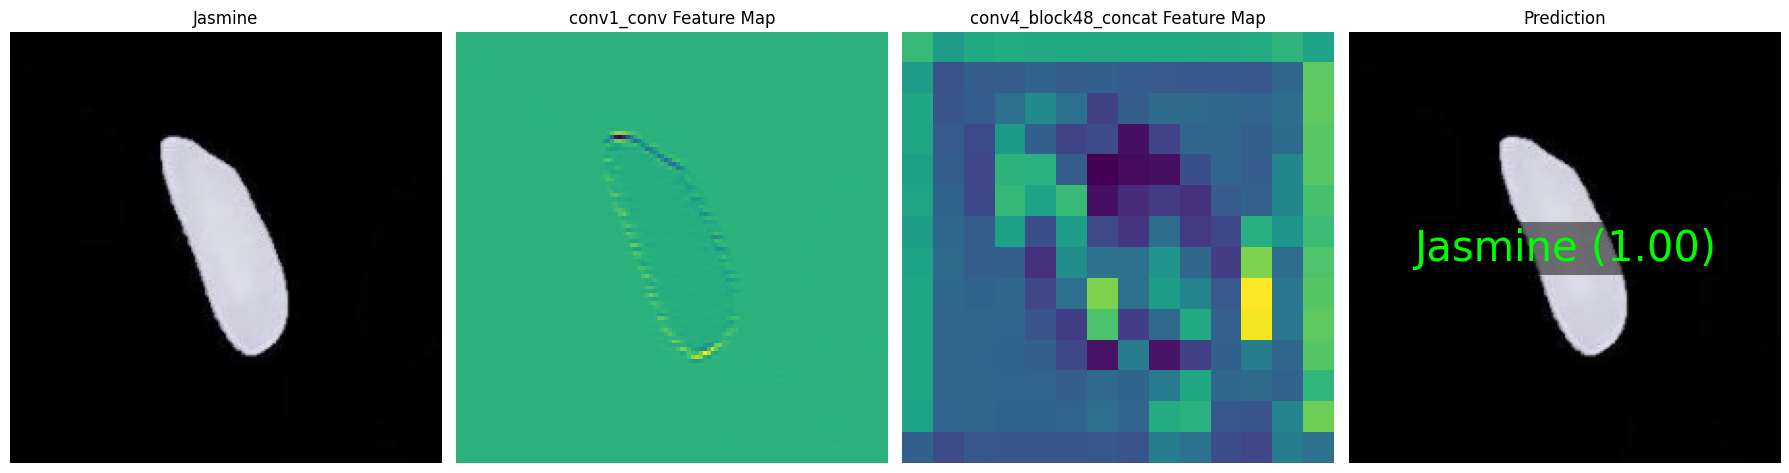

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


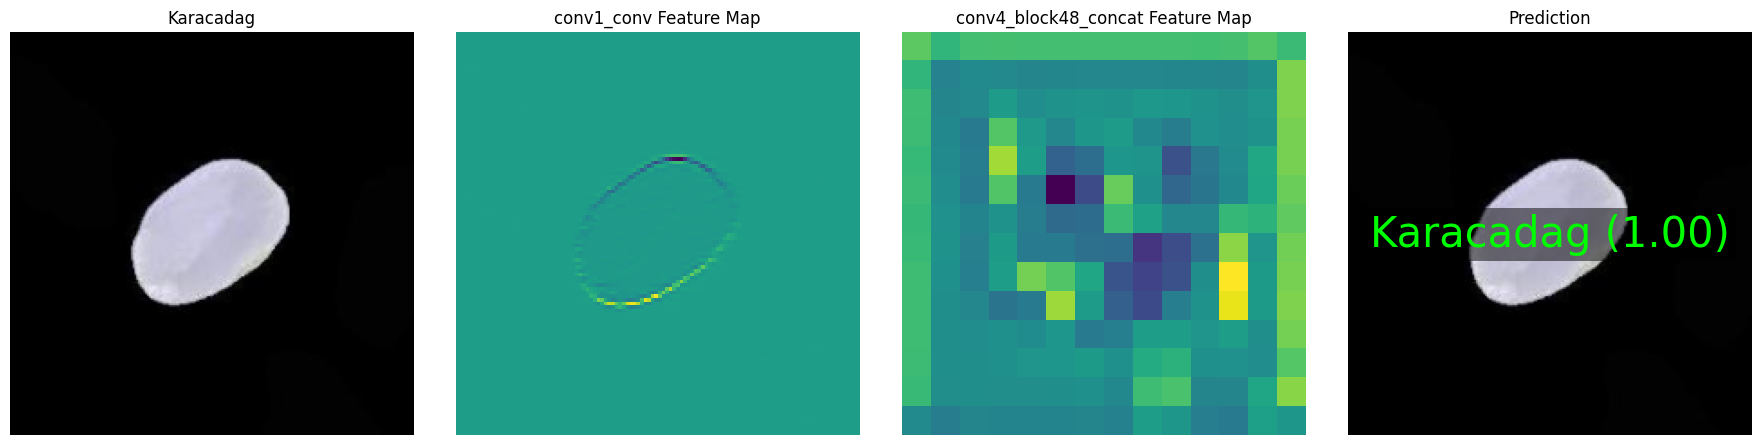

In [ ]:
# Predict sample of eachh class
seed_value = 42
random.seed(seed_value)

base_dir = 'imgs/test'
layer_names = ['conv1_conv', 'conv4_block48_concat']
feature_map_models = {}
for layer_name in layer_names:
    feature_map_models[layer_name] = Model(inputs=densincep_model.input, outputs=densincep_model.get_layer(layer_name).output)

# Pick random img
def rand_img(class_name):
    class_dir = os.path.join(base_dir, class_name)
    image_names = os.listdir(class_dir)
    random_image_name = random.choice(image_names)
    image_path = os.path.join(class_dir, random_image_name)
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (224, 224))
    img_array = np.expand_dims(img_resized, axis=0) / 255.0
    return img_resized, img_array, random_image_name

# Pred n Feature map
def viz_result(class_name, img_resized, img_array):
    predictions = densincep_model.predict(img_array)[0]
    predicted_class = np.argmax(predictions)
    predicted_probability = predictions[predicted_class]
    predicted_class_name = rice_classes[predicted_class]

    plt.figure(figsize=(18, 6))

    # Ori
    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
    plt.title(f"{class_name}")
    plt.axis('off')

    # Feature Map 'conv1_conv'
    feature_maps_conv1 = feature_map_models['conv1_conv'].predict(img_array)
    plt.subplot(1, 4, 2)
    plt.imshow(feature_maps_conv1[0, :, :, 0], cmap='viridis')
    plt.title('conv1_conv Feature Map')
    plt.axis('off')

    # Feature Map 'conv4_block48_concat'
    feature_maps_conv4 = feature_map_models['conv4_block48_concat'].predict(img_array)
    plt.subplot(1, 4, 3)
    plt.imshow(feature_maps_conv4[0, :, :, 0], cmap='viridis')
    plt.title('conv4_block48_concat Feature Map')
    plt.axis('off')

    # Pred
    plt.subplot(1, 4, 4)
    plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.text(
        112, 112,
        f'{predicted_class_name} ({predicted_probability:.2f})',
        color='lime',
        fontsize=30,
        ha='center',
        va='center',
        bbox=dict(facecolor='black', alpha=0.5, edgecolor='none')
    )
    plt.title("Prediction")
    plt.tight_layout()
    plt.show()

for class_name in rice_classes:
    img_resized, img_array, image_name = rand_img(class_name)
    viz_result(class_name, img_resized, img_array)


#8.&nbsp;Model Comparison


In [ ]:
# define func that use for all model
def create_model(base_model, input_shape=(224, 224, 3), num_classes=5):
    inputs = Input(shape=input_shape)
    base = base_model(include_top=False, weights='imagenet', input_tensor=inputs)

    for layer in base.layers:
        layer.trainable = False

    x = base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    other_model = Model(inputs=inputs, outputs=outputs)
    return other_model

input_shape = (224, 224, 3)
num_classes = 5

vgg19_model = create_model(VGG19, input_shape=input_shape, num_classes=num_classes)
resnet50_model = create_model(ResNet50, input_shape=input_shape, num_classes=num_classes)
densenet201_model = create_model(DenseNet201, input_shape=input_shape, num_classes=num_classes)
inceptionv3_model = create_model(InceptionV3, input_shape=input_shape, num_classes=num_classes)

optimizer = Adam(learning_rate=0.001)
loss = CategoricalCrossentropy()
metrics = ['accuracy']

for other_model in [vgg19_model, resnet50_model, densenet201_model, inceptionv3_model]:
    other_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


##8.1.&nbsp;VGG19

In [ ]:
history_vgg19_model_10_epoch = vgg19_model.fit(train_data, epochs=10, validation_data=test_data)

Epoch 1/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 404s 464ms/step - accuracy: 0.8351 - loss: 0.5381 - val_accuracy: 0.9772 - val_loss: 0.0827
Epoch 2/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 393s 430ms/step - accuracy: 0.9748 - loss: 0.0839 - val_accuracy: 0.9833 - val_loss: 0.0566
Epoch 3/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 381s 429ms/step - accuracy: 0.9771 - loss: 0.0697 - val_accuracy: 0.9840 - val_loss: 0.0509
Epoch 4/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 392s 477ms/step - accuracy: 0.9820 - loss: 0.0536 - val_accuracy: 0.9851 - val_loss: 0.0457
Epoch 5/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 402s 429ms/step - accuracy: 0.9844 - loss: 0.0474 - val_accuracy: 0.9853 - val_loss: 0.0441
Epoch 6/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 351s 426ms/step - accuracy: 0.9857 - loss: 0.0446 - val_accuracy: 0.9821 - val_loss: 0.0507
Epoch 7/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 350s 426ms/step - accuracy: 0.9868 - loss: 0.0416 - val_accuracy: 0.9872 - val_loss: 0.0386
Epoch 8/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 382s 426ms/step - accuracy: 0.9879 -

In [ ]:
vgg19_model.save('vgg19_model_10epoch.keras')

In [ ]:
history_vgg19_model = vgg19_model.fit(train_data, epochs=30, validation_data=test_data)

Epoch 1/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 418s 480ms/step - accuracy: 0.8441 - loss: 0.5456 - val_accuracy: 0.9746 - val_loss: 0.0922
Epoch 2/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 391s 445ms/step - accuracy: 0.9729 - loss: 0.0888 - val_accuracy: 0.9802 - val_loss: 0.0646
Epoch 3/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 382s 446ms/step - accuracy: 0.9803 - loss: 0.0649 - val_accuracy: 0.9800 - val_loss: 0.0618
Epoch 4/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 367s 447ms/step - accuracy: 0.9831 - loss: 0.0558 - val_accuracy: 0.9816 - val_loss: 0.0555
Epoch 5/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 367s 447ms/step - accuracy: 0.9848 - loss: 0.0477 - val_accuracy: 0.9873 - val_loss: 0.0401
Epoch 6/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 417s 489ms/step - accuracy: 0.9835 - loss: 0.0487 - val_accuracy: 0.9884 - val_loss: 0.0371
Epoch 7/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 366s 445ms/step - accuracy: 0.9879 - loss: 0.0380 - val_accuracy: 0.9825 - val_loss: 0.0539
Epoch 8/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 418s 489ms/step - accuracy: 0.9878 -

In [ ]:
vgg19_model.save('vgg19_model.keras')

##8.2.&nbsp;ResNet50

In [ ]:
optimizer = Adam(learning_rate=0.001)
loss = CategoricalCrossentropy()
metrics = ['accuracy']

resnet50_model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [ ]:
history_resnet50_model_10_epoch = resnet50_model.fit(train_data, epochs=10, validation_data=test_data)

Epoch 1/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 225s 258ms/step - accuracy: 0.8224 - loss: 0.5095 - val_accuracy: 0.9551 - val_loss: 0.1331
Epoch 2/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 240s 240ms/step - accuracy: 0.9534 - loss: 0.1354 - val_accuracy: 0.9477 - val_loss: 0.1361
Epoch 3/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 196s 238ms/step - accuracy: 0.9596 - loss: 0.1119 - val_accuracy: 0.9676 - val_loss: 0.0941
Epoch 4/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 204s 241ms/step - accuracy: 0.9632 - loss: 0.1009 - val_accuracy: 0.9443 - val_loss: 0.1462
Epoch 5/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 200s 238ms/step - accuracy: 0.9667 - loss: 0.0925 - val_accuracy: 0.9723 - val_loss: 0.0832
Epoch 6/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 197s 239ms/step - accuracy: 0.9694 - loss: 0.0835 - val_accuracy: 0.9708 - val_loss: 0.0811
Epoch 7/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 197s 239ms/step - accuracy: 0.9703 - loss: 0.0849 - val_accuracy: 0.9685 - val_loss: 0.0856
Epoch 8/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 226s 269ms/step - accuracy: 0.9673 -

In [ ]:
resnet50_model.save('resnet50_model_10epoch.keras')

In [ ]:
history_resnet50_model = resnet50_model.fit(train_data, epochs=30, validation_data=test_data)

Epoch 1/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 220s 251ms/step - accuracy: 0.8165 - loss: 0.5073 - val_accuracy: 0.9436 - val_loss: 0.1598
Epoch 2/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 219s 266ms/step - accuracy: 0.9500 - loss: 0.1416 - val_accuracy: 0.9584 - val_loss: 0.1190
Epoch 3/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 234s 232ms/step - accuracy: 0.9618 - loss: 0.1100 - val_accuracy: 0.9626 - val_loss: 0.1118
Epoch 4/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 194s 236ms/step - accuracy: 0.9619 - loss: 0.1073 - val_accuracy: 0.9703 - val_loss: 0.0881
Epoch 5/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 227s 266ms/step - accuracy: 0.9676 - loss: 0.0922 - val_accuracy: 0.9735 - val_loss: 0.0770
Epoch 6/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 238s 237ms/step - accuracy: 0.9698 - loss: 0.0848 - val_accuracy: 0.9675 - val_loss: 0.0937
Epoch 7/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 192s 233ms/step - accuracy: 0.9673 - loss: 0.0891 - val_accuracy: 0.9671 - val_loss: 0.0980
Epoch 8/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 203s 235ms/step - accuracy: 0.9712 -

In [ ]:
resnet50_model.save('resnet50_model.keras')

##8.3.&nbsp;DenseNet201

In [ ]:
optimizer = Adam(learning_rate=0.001)
loss = CategoricalCrossentropy()
metrics = ['accuracy']

densenet201_model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [ ]:
history_densenet201_model_10_epoch = densenet201_model.fit(train_data, epochs=10, validation_data=test_data)

Epoch 1/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 345s 377ms/step - accuracy: 0.9592 - loss: 0.1210 - val_accuracy: 0.9935 - val_loss: 0.0198
Epoch 2/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 273s 332ms/step - accuracy: 0.9918 - loss: 0.0250 - val_accuracy: 0.9937 - val_loss: 0.0168
Epoch 3/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 275s 335ms/step - accuracy: 0.9931 - loss: 0.0202 - val_accuracy: 0.9933 - val_loss: 0.0195
Epoch 4/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 322s 335ms/step - accuracy: 0.9940 - loss: 0.0173 - val_accuracy: 0.9950 - val_loss: 0.0149
Epoch 5/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 324s 338ms/step - accuracy: 0.9947 - loss: 0.0139 - val_accuracy: 0.9933 - val_loss: 0.0216
Epoch 6/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 275s 334ms/step - accuracy: 0.9959 - loss: 0.0142 - val_accuracy: 0.9957 - val_loss: 0.0138
Epoch 7/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 323s 335ms/step - accuracy: 0.9957 - loss: 0.0125 - val_accuracy: 0.9923 - val_loss: 0.0243
Epoch 8/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 276s 336ms/step - accuracy: 0.9957 -

In [ ]:
densenet201_model.save('densenet201_model_10epoch.keras')

In [ ]:
history_densenet201_model = densenet201_model.fit(train_data, epochs=30, validation_data=test_data)

Epoch 1/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 381s 399ms/step - accuracy: 0.9539 - loss: 0.1305 - val_accuracy: 0.9904 - val_loss: 0.0280
Epoch 2/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 296s 332ms/step - accuracy: 0.9913 - loss: 0.0272 - val_accuracy: 0.9943 - val_loss: 0.0170
Epoch 3/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 322s 332ms/step - accuracy: 0.9932 - loss: 0.0200 - val_accuracy: 0.9924 - val_loss: 0.0224
Epoch 4/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 273s 331ms/step - accuracy: 0.9932 - loss: 0.0188 - val_accuracy: 0.9820 - val_loss: 0.0555
Epoch 5/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 274s 333ms/step - accuracy: 0.9949 - loss: 0.0134 - val_accuracy: 0.9944 - val_loss: 0.0165
Epoch 6/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 322s 333ms/step - accuracy: 0.9958 - loss: 0.0114 - val_accuracy: 0.9960 - val_loss: 0.0127
Epoch 7/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 322s 333ms/step - accuracy: 0.9953 - loss: 0.0137 - val_accuracy: 0.9962 - val_loss: 0.0115
Epoch 8/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 274s 333ms/step - accuracy: 0.9956 -

In [ ]:
densenet201_model.save('densenet201_model.keras')

##8.4.&nbsp;InceptionV3

In [ ]:
optimizer = Adam(learning_rate=0.001)
loss = CategoricalCrossentropy()
metrics = ['accuracy']

inceptionv3_model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

In [ ]:
history_inceptionv3_model_10_epoch = inceptionv3_model.fit(train_data, epochs=10, validation_data=test_data)

Epoch 1/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 257s 284ms/step - accuracy: 0.9352 - loss: 0.2432 - val_accuracy: 0.9854 - val_loss: 0.0449
Epoch 2/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 185s 206ms/step - accuracy: 0.9852 - loss: 0.0433 - val_accuracy: 0.9851 - val_loss: 0.0474
Epoch 3/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 195s 199ms/step - accuracy: 0.9881 - loss: 0.0375 - val_accuracy: 0.9808 - val_loss: 0.0643
Epoch 4/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 202s 199ms/step - accuracy: 0.9892 - loss: 0.0321 - val_accuracy: 0.9917 - val_loss: 0.0276
Epoch 5/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 200s 242ms/step - accuracy: 0.9921 - loss: 0.0240 - val_accuracy: 0.9877 - val_loss: 0.0389
Epoch 6/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 165s 198ms/step - accuracy: 0.9916 - loss: 0.0253 - val_accuracy: 0.9898 - val_loss: 0.0298
Epoch 7/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 238s 241ms/step - accuracy: 0.9938 - loss: 0.0183 - val_accuracy: 0.9884 - val_loss: 0.0361
Epoch 8/10
821/821 ━━━━━━━━━━━━━━━━━━━━ 168s 200ms/step - accuracy: 0.9939 -

In [ ]:
inceptionv3_model.save("inceptionv3_model_10epoch.keras")

In [ ]:
history_inceptionv3_model = inceptionv3_model.fit(train_data, epochs=30, validation_data=test_data)

Epoch 1/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 216s 235ms/step - accuracy: 0.9326 - loss: 0.2274 - val_accuracy: 0.9869 - val_loss: 0.0407
Epoch 2/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 165s 200ms/step - accuracy: 0.9857 - loss: 0.0428 - val_accuracy: 0.9842 - val_loss: 0.0472
Epoch 3/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 198s 196ms/step - accuracy: 0.9873 - loss: 0.0364 - val_accuracy: 0.9844 - val_loss: 0.0477
Epoch 4/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 161s 196ms/step - accuracy: 0.9891 - loss: 0.0311 - val_accuracy: 0.9883 - val_loss: 0.0368
Epoch 5/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 159s 192ms/step - accuracy: 0.9904 - loss: 0.0292 - val_accuracy: 0.9865 - val_loss: 0.0397
Epoch 6/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 162s 196ms/step - accuracy: 0.9916 - loss: 0.0259 - val_accuracy: 0.9900 - val_loss: 0.0325
Epoch 7/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 159s 193ms/step - accuracy: 0.9927 - loss: 0.0219 - val_accuracy: 0.9892 - val_loss: 0.0345
Epoch 8/30
821/821 ━━━━━━━━━━━━━━━━━━━━ 159s 193ms/step - accuracy: 0.9936 -

In [ ]:
inceptionv3_model.save("inceptionv3_model.keras")

#9.&nbsp; Deployment Testing

In [ ]:
model = load_model('/content/densincep_model.keras')

Saving Karacadag (1002).jpg to Karacadag (1002).jpg


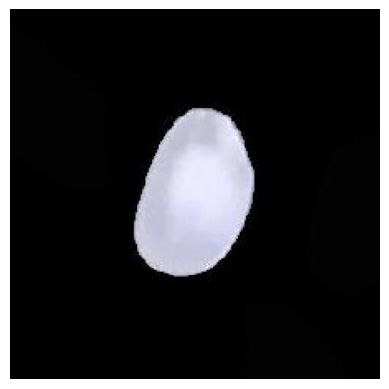

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
File: Karacadag (1002).jpg
Kelas teridentifikasi: Karacadag


In [ ]:
class_names = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

def color_text(text, color_code='33'):
    return f"\033[1;{color_code}m{text}\033[0m"

uploaded = files.upload()

for fn in uploaded.keys():
    path = fn
    img = image.load_img(path, target_size=(224, 224))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0

    predictions = model.predict(x)
    predicted_class = np.argmax(predictions, axis=1)[0]

    print(f'File: {fn}')
    print(f'Kelas teridentifikasi: {color_text(class_names[predicted_class], "33")}')

#10.&nbsp; Model Visualization

## Model Comparison (My own training)

In [ ]:
# i need to visualize the accuracy each model
data = {
    'Model': ['VGG19', 'ResNet50', 'DenseNet201', 'InceptionV3', 'DENS-INCEP'],
    'Training Accuracy': [0.9912, 0.9801, 0.9995, 0.9985, 0.9996],
    'Testing Accuracy': [0.9910, 0.9732, 0.9966, 0.9939, 0.9986],
}
df = pd.DataFrame(data)

df_accuracy = df.melt(id_vars="Model", value_vars=["Training Accuracy", "Testing Accuracy"],
                      var_name="Metric", value_name="Accuracy")

df_accuracy = df_accuracy.sort_values(by="Accuracy", ascending=False)

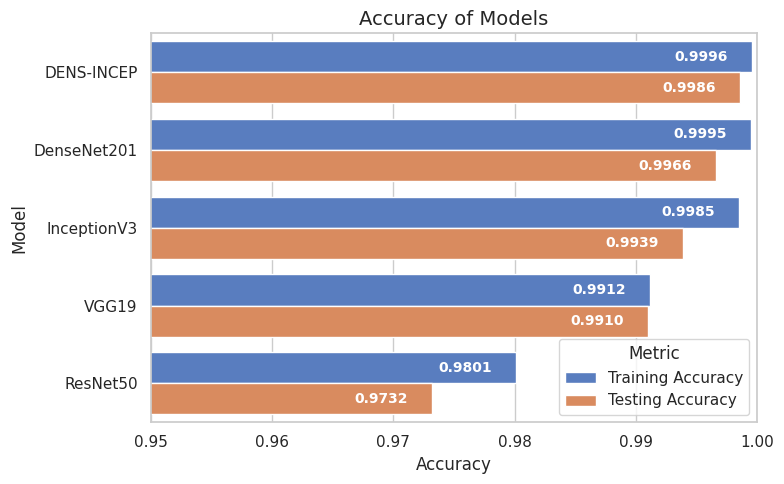

In [ ]:
# lets vizualize 'em
sns.set_theme(style="whitegrid")

def add_labels_inside(ax):
    for p in ax.patches:
        value = p.get_width()
        if value > 0.95:
            ax.annotate(f"{value:.4f}",
                        (p.get_width() - 0.002, p.get_y() + p.get_height() / 2),
                        ha='right', va='center', color='white', fontsize=10, fontweight='bold')

plt.figure(figsize=(8, 5))
ax1 = sns.barplot(y="Model", x="Accuracy", hue="Metric", data=df_accuracy, palette="muted")
plt.title("Accuracy of Models", fontsize=14)
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.xlim(0.95, 1.0)
plt.legend(title="Metric", loc='lower right')
add_labels_inside(ax1)
plt.tight_layout()
plt.show()

## Scenario Comparison (DENS-INCEP)

In [ ]:
rice_classes = list(test_data.class_indices.keys())
num_classes = len(rice_classes)

def evaluate_model(model_path, test_data, rice_classes, title):
    model = load_model(model_path)
    Y_pred = model.predict(test_data)
    y_pred = np.argmax(Y_pred, axis=1)

    confusion_mtx = confusion_matrix(test_data.classes, y_pred)
    accuracy_per_class = []
    sensitivity_per_class = []
    specificity_per_class = []

    for i in range(num_classes):
        TP = confusion_mtx[i, i]
        FP = sum(confusion_mtx[:, i]) - TP
        FN = sum(confusion_mtx[i, :]) - TP
        TN = sum(sum(confusion_mtx)) - (TP + FP + FN)

        accuracy = (TP + TN) / (TP + TN + FP + FN)
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

        accuracy_per_class.append(accuracy * 100)
        sensitivity_per_class.append(sensitivity * 100)
        specificity_per_class.append(specificity * 100)

    results_df = pd.DataFrame({
        "Class": rice_classes,
        "Accuracy (%)": accuracy_per_class,
        "Sensitivity (%)": sensitivity_per_class,
        "Specificity (%)": specificity_per_class
    })

    avg_accuracy = np.mean(accuracy_per_class)
    avg_sensitivity = np.mean(sensitivity_per_class)
    avg_specificity = np.mean(specificity_per_class)
    results_df.loc["Average"] = ["Average", avg_accuracy, avg_sensitivity, avg_specificity]

    return results_df

model_paths = {
    "10 Epoch LR 0.001": "/content/densincep_model_10epoch_lr001.keras",
    "10 Epoch LR 0.0001": "/content/densincep_model_10epoch_lr0001.keras",
    "20 Epoch LR 0.001": "/content/densincep_model_20epoch_lr001.keras",
    "20 Epoch LR 0.0001": "/content/densincep_model_20epoch_lr0001.keras",
    "30 Epoch LR 0.001": "/content/densincep_model_30epoch_lr001.keras",
    "30 Epoch LR 0.0001": "/content/densincep_model_30epoch_lr0001.keras",
}

for title, model_path in model_paths.items():
    print(f"Evaluating {title}")
    results_df = evaluate_model(model_path, test_data, rice_classes, title)
    print(results_df)

Evaluating 10 Epoch LR 0.001
352/352 ━━━━━━━━━━━━━━━━━━━━ 106s 251ms/step
             Class  Accuracy (%)  Sensitivity (%)  Specificity (%)
0          Arborio     99.880000        99.844444        99.888889
1          Basmati     99.911111        99.600000        99.988889
2           Ipsala     99.964444        99.822222       100.000000
3          Jasmine     99.853333        99.866667        99.850000
4        Karacadag     99.928889        99.711111        99.983333
Average    Average     99.907556        99.768889        99.942222
Evaluating 10 Epoch LR 0.0001
352/352 ━━━━━━━━━━━━━━━━━━━━ 102s 251ms/step
             Class  Accuracy (%)  Sensitivity (%)  Specificity (%)
0          Arborio     99.760000        98.911111        99.972222
1          Basmati     99.893333        99.800000        99.916667
2           Ipsala     99.951111        99.755556       100.000000
3          Jasmine     99.666667        99.688889        99.661111
4        Karacadag     99.928889        99.8444

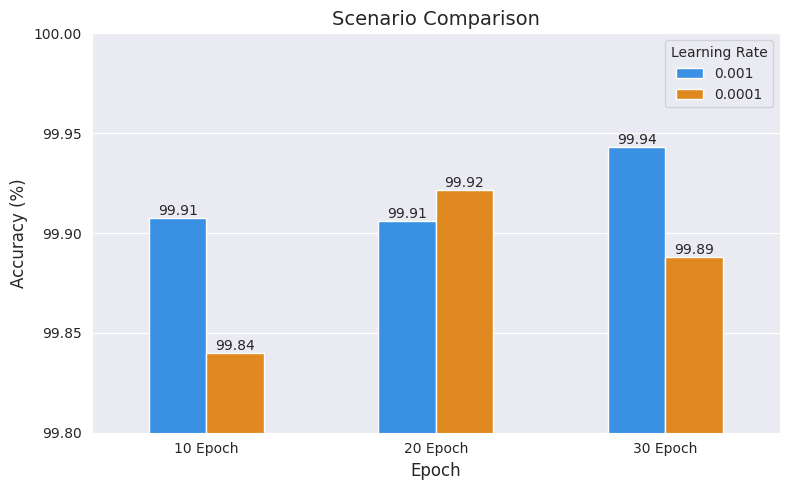

In [ ]:
# based on the avg accuracy of all model scenario, i want to visualize 'em as bar chart
# so step 1. Create Dataframe that save all necessary info
# step 2. just make a grouped bar chart

data = {
    "Epoch": ["10 Epoch", "10 Epoch", "20 Epoch", "20 Epoch", "30 Epoch", "30 Epoch"],
    "Learning Rate": [0.001, 0.0001, 0.001, 0.0001, 0.001, 0.0001],
    "Accuracy": [99.907556, 99.840000, 99.905778, 99.921778, 99.943111, 99.888000]
}

df = pd.DataFrame(data)

plt.figure(figsize=(8, 5))
sns.barplot(
    data=df,
    x="Epoch",
    y="Accuracy",
    hue="Learning Rate",
    hue_order=[0.001, 0.0001],
    palette=["dodgerblue", "darkorange"],
    width=0.5
)

for container in plt.gca().containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            plt.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f"{height:.2f}",
                ha='center',
                va='bottom',
                fontsize=10
            )

plt.yticks(ticks=[99.8, 99.85, 99.9, 99.95, 100], fontsize=10)
plt.title("Scenario Comparison", fontsize=14)
plt.ylim(99.8, 100)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.xlabel("Epoch", fontsize=12)
plt.legend(title="Learning Rate", fontsize=10, title_fontsize=10)

plt.tight_layout()
plt.show()


## Model Comparison (Other Studies)

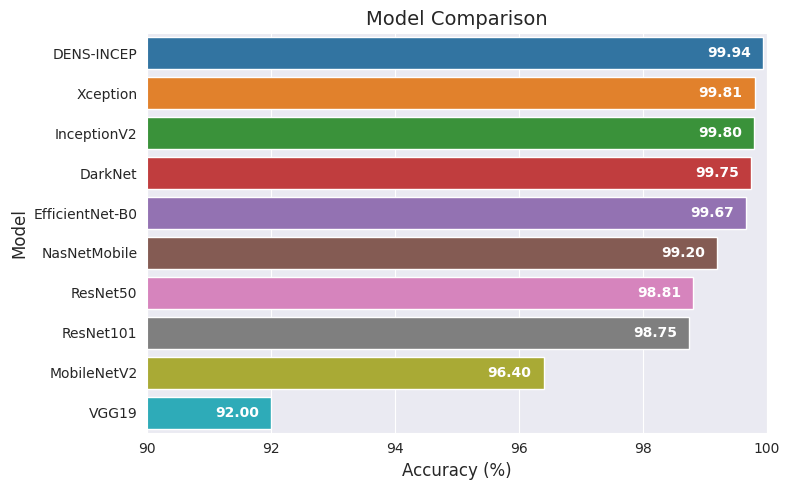

In [ ]:
data = {
    "Model": ["NasNetMobile", "EfficientNet-B0", "InceptionV2", "Xception", "DarkNet",
              "VGG19", "ResNet50", "ResNet101", "MobileNetV2", "DENS-INCEP"],
    "Accuracy": [99.20, 99.67, 99.80, 99.81, 99.75, 92, 98.813, 98.747, 96.4, 99.94]
}
df_other = pd.DataFrame(data)
df_other = df_other.sort_values(by="Accuracy", ascending=False)

def add_labels_inside(ax):
    for p in ax.patches:
        value = p.get_width()
        if value > 0.95:
            ax.annotate(f"{value:.2f}",
                        (p.get_width() - 0.2, p.get_y() + p.get_height() / 2),
                        ha='right', va='center', color='white', fontsize=10, fontweight='bold')

sns.set_style('darkgrid')
plt.figure(figsize=(8, 5))
ax1 = sns.barplot(data=df_other,
                  x="Accuracy",
                  y="Model",
                  hue="Model")
plt.title("Model Comparison", fontsize=14)
plt.xlabel("Accuracy (%)", fontsize=12)
plt.ylabel("Model", fontsize=12)
plt.xlim(90, 100)
add_labels_inside(ax1)
plt.tight_layout()
plt.show()

#11.&nbsp;Model Profiling

In [ ]:
import time
start_time = time.time()
predictions = densincep_model.predict(test_data)
end_time = time.time()
inference_time = end_time - start_time
print(f"Time taken for inference: {inference_time} seconds")

# throughput = len(test_data) / inference_time
# print(f"Throughput: {throughput} samples/second")

352/352 ━━━━━━━━━━━━━━━━━━━━ 78s 221ms/step
Time taken for inference: 78.6060848236084 seconds


In [ ]:
!nvidia-smi

Mon Mar 17 15:50:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   73C    P0             33W /   70W |    8314MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
model_size = os.path.getsize('/content/densincep_model_30epoch_lr001.keras')
print(f"Model size: {model_size / (1024 * 1024)} MB")

Model size: 89.50271511077881 MB


The total inference time of 78 seconds for 352 batches indicates that the time taken to produce predictions from one batch is approximately 0.22 seconds. This shows that the model performs efficiently in providing predictions with low latency, which is crucial for applications requiring rapid inference at scale.

In [ ]:
!pip install memory-profile

In [ ]:
from memory_profiler import memory_usage

def predict():
    densincep_model.predict(test_data)

mem_usage = memory_usage(predict)
print(f"Memory usage during inference: {max(mem_usage)} MB")

352/352 ━━━━━━━━━━━━━━━━━━━━ 80s 225ms/step
Memory usage during inference: 3696.0078125 MB


The GPU memory usage of 54% out of the total 16 GB indicates efficient memory usage. The DENS-INCEP model does not reach the memory capacity limit, meaning there is no risk of running out of memory during inference. This usage is considered optimal, with enough memory available to continue inference without any memory-related issues.

The model size of 89.5 MB indicates that the DENS-INCEP model is relatively small compared to other deep learning models like VGG16 or ResNet50, which are typically much larger. This smaller model size contributes to faster loading times and more efficient memory usage, making it suitable for deployment in resource-constrained environments.